# Clickbait Detection Project: Proof of Concept

**Course:** NLP Course, Winter 2025  
**Authors:** Jakub Sawicki, Jędrzej Sokołowski, Wiktor Woźniak  
**Supervisor:** Anna Wróblewska

In [ ]:
!pip install pandas numpy scikit-learn nltk textblob transformers torch matplotlib seaborn tqdm

  Using cached pandas-2.3.3-cp312-cp312-win_amd64.whl.metadata (19 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached pyyaml-6.0.3-cp312-cp312-win_amd64.whl.metadata (2.4 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached tokenizers-0.22.1-cp39-abi3-win_amd64.whl.metadata (6.9 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached contourpy-1.3.3-cp312-cp312-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.9-cp312-cp312-win_amd64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
  Using cached mpmath-1.3.0-py3-none

In [1]:
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from scipy.sparse import save_npz
from sklearn.model_selection import GridSearchCV
import json

# Ensure NLTK resources are downloaded
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

# Set seeds for reproducibility
np.random.seed(42)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jakub\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\jakub\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jakub\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jakub\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Data Loading

In [2]:
from prepare_data import *

cb_2017 = load_webis_corpus_2017()
cb_2022 = load_webis_corpus_2022()

Successfully loaded data.
Dataset shape: (21997, 2)
Successfully loaded data.
Dataset shape: (4000, 2)


In [3]:
len(cb_2017[cb_2017["label"]==0])/len(cb_2017[cb_2017["label"]==1])

2.9827992033315227

Text(0.5, 1.0, 'Webis Corpus 2017 Class Distribution')

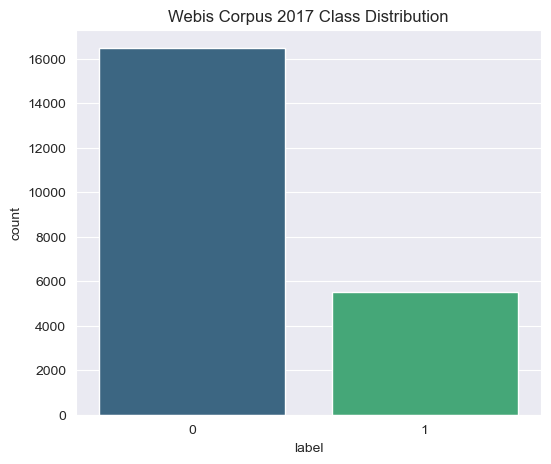

In [4]:
plt.figure(figsize=(6, 5))
sns.countplot(x='label', data=cb_2017, hue='label', palette='viridis', legend=False)
plt.title("Webis Corpus 2017 Class Distribution")

### We can see a great imbalance in the class distribution, to combat that, we extend the dataset with only clickbait data from Webis Clickbait Spoiling Corpus 2022

In [5]:
# models will be trained and fine-tuned using training set with cross-validation / validation loss monitoring
# validation set will be used for comparison between models
# test set may be used for final results of the best model (approach)
# 60/20/20 split

train_df, val_test_df = prepare_english_data(test_size=0.6)
val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=42, stratify=val_test_df['label'])

print("Saving raw merged data...")
os.makedirs('data/merged', exist_ok=True)
train_df.to_csv('data/merged/train.csv', index=True)
val_df.to_csv('data/merged/val.csv', index=True)
test_df.to_csv('data/merged/test.csv', index=True)
print("The data has been saved.")

print(f"\nTraining set: {len(train_df)}")
print(f"Validation set: {len(val_df)}")
print(f"Test set: {len(test_df)}")

Successfully loaded data.
Dataset shape: (21997, 2)
Successfully loaded data.
Dataset shape: (4000, 2)
Removed 54 rows with missing or empty headlines.
Total Samples: 25943
Training Set: 10377
Validation Set: 15566

Class Balance (Train):
label
0    6586
1    3791
Name: count, dtype: int64
Saving raw merged data...
The data has been saved.

Training set: 10377
Validation set: 7783
Test set: 7783


## 2. Feature Engineering
Extracting linguistic features as defined in the project plan.

In [6]:
sample_features = perform_feature_engineering_manually(train_df['headline'])
print("Feature Vector Shape:", sample_features.shape)

feature_column_names = [
    'ft_char_count',
    'ft_word_count',
    'ft_exclamation',
    'ft_question',
    'ft_all_caps',
    'ft_polarity',
    'ft_subjectivity',
    'ft_starts_q'
]

sample_features_df = pd.DataFrame(
    sample_features,
    columns=feature_column_names
)

sample_features_df.index = train_df.index
final_df = pd.concat([train_df, sample_features_df], axis=1)

print(f"Final df shape: {final_df.shape}")
final_df.head()

Feature Vector Shape: (10377, 8)
Final df shape: (10377, 10)


,headline,label,ft_char_count,ft_word_count,ft_exclamation,ft_question,ft_all_caps,ft_polarity,ft_subjectivity,ft_starts_q
856,"They are the cream of the crop, the best of th...",0,91.0,18.0,0.0,0.0,0.0,1.0,0.3,0.0
6990,The 20 funniest tweets from women this week,1,43.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0
2742,Science Explains Why Glitter Sticks to Everything,1,49.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0
1271,"Whistleblowers testify on gov’t backlash, DHS ...",0,94.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0
3643,Pres. Trump considering executive actions on a...,0,81.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
print("Saving data with custom features...")
os.makedirs('data/custom_features', exist_ok=True)
final_df.to_csv('data/custom_features/data.csv', index=True)
print("The data has been saved.")

Saving data with custom features...
The data has been saved.


## 3. Exploratory Data Analysis (EDA)
Basic analysis of class distribution and text features.

In [8]:
plt.rcParams["font.size"] = 11

Text(0.5, 0, 'Label (0=Non-Clickbait, 1=Clickbait)')

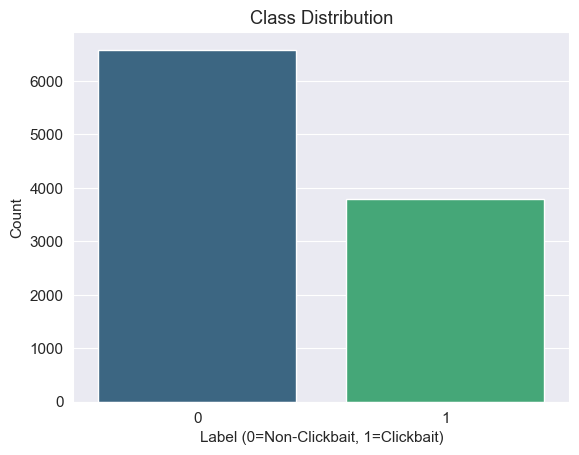

In [9]:
if len(final_df['label'].unique()) > 1:
    sns.countplot(x='label', data=final_df, hue='label', palette='viridis', legend=False)
else:
    final_df['label'].value_counts().plot(kind='bar', color='teal')
plt.title('Class Distribution')
plt.ylabel('Count')
plt.xlabel('Label (0=Non-Clickbait, 1=Clickbait)')

In [10]:
len(train_df[train_df["label"]==0])/len(train_df[train_df["label"]==1])


1.7372724874703245

C:\Users\jakub\AppData\Local\Temp\ipykernel_18060\3528471127.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


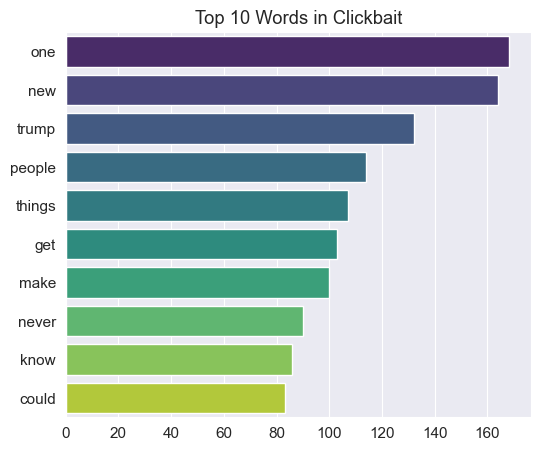

C:\Users\jakub\AppData\Local\Temp\ipykernel_18060\3528471127.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


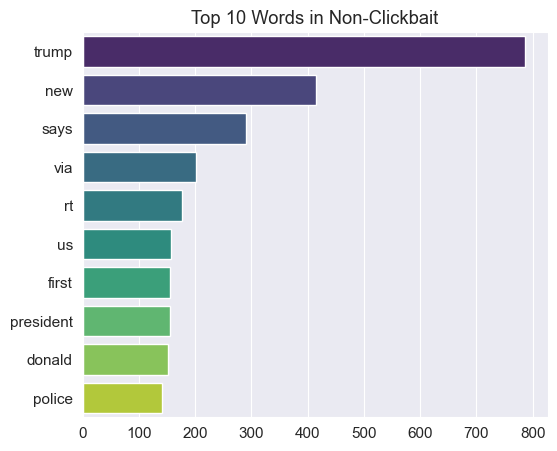

In [11]:
def plot_top_words(df, label, n=10):
    subset = df[df['label'] == label]
    if len(subset) == 0: return

    all_text = " ".join(subset['headline'].astype(str))
    tokens = nltk.word_tokenize(all_text.lower())
    # Remove stopwords and punctuation
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokens = [w for w in tokens if w.isalnum() and w not in stop_words]

    common_words = Counter(tokens).most_common(n)
    words, counts = zip(*common_words)

    plt.figure(figsize=(6, 5))

    sns.barplot(x=list(counts), y=list(words), palette='viridis')
    plt.title(f'Top {n} Words in {"Clickbait" if label==1 else "Non-Clickbait"}')
    plt.show()

plot_top_words(train_df, 1)
plot_top_words(train_df, 0)

In [12]:
plt.rcParams["font.size"] = 25

C:\Users\jakub\AppData\Local\Temp\ipykernel_18060\3934004348.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='ft_word_count', data=df, palette='viridis')


Visualizing All Features (Original + Extracted)


C:\Users\jakub\AppData\Local\Temp\ipykernel_18060\3934004348.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y=feature, data=df, palette='viridis')
C:\Users\jakub\AppData\Local\Temp\ipykernel_18060\3934004348.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y=feature, data=df, palette='viridis')


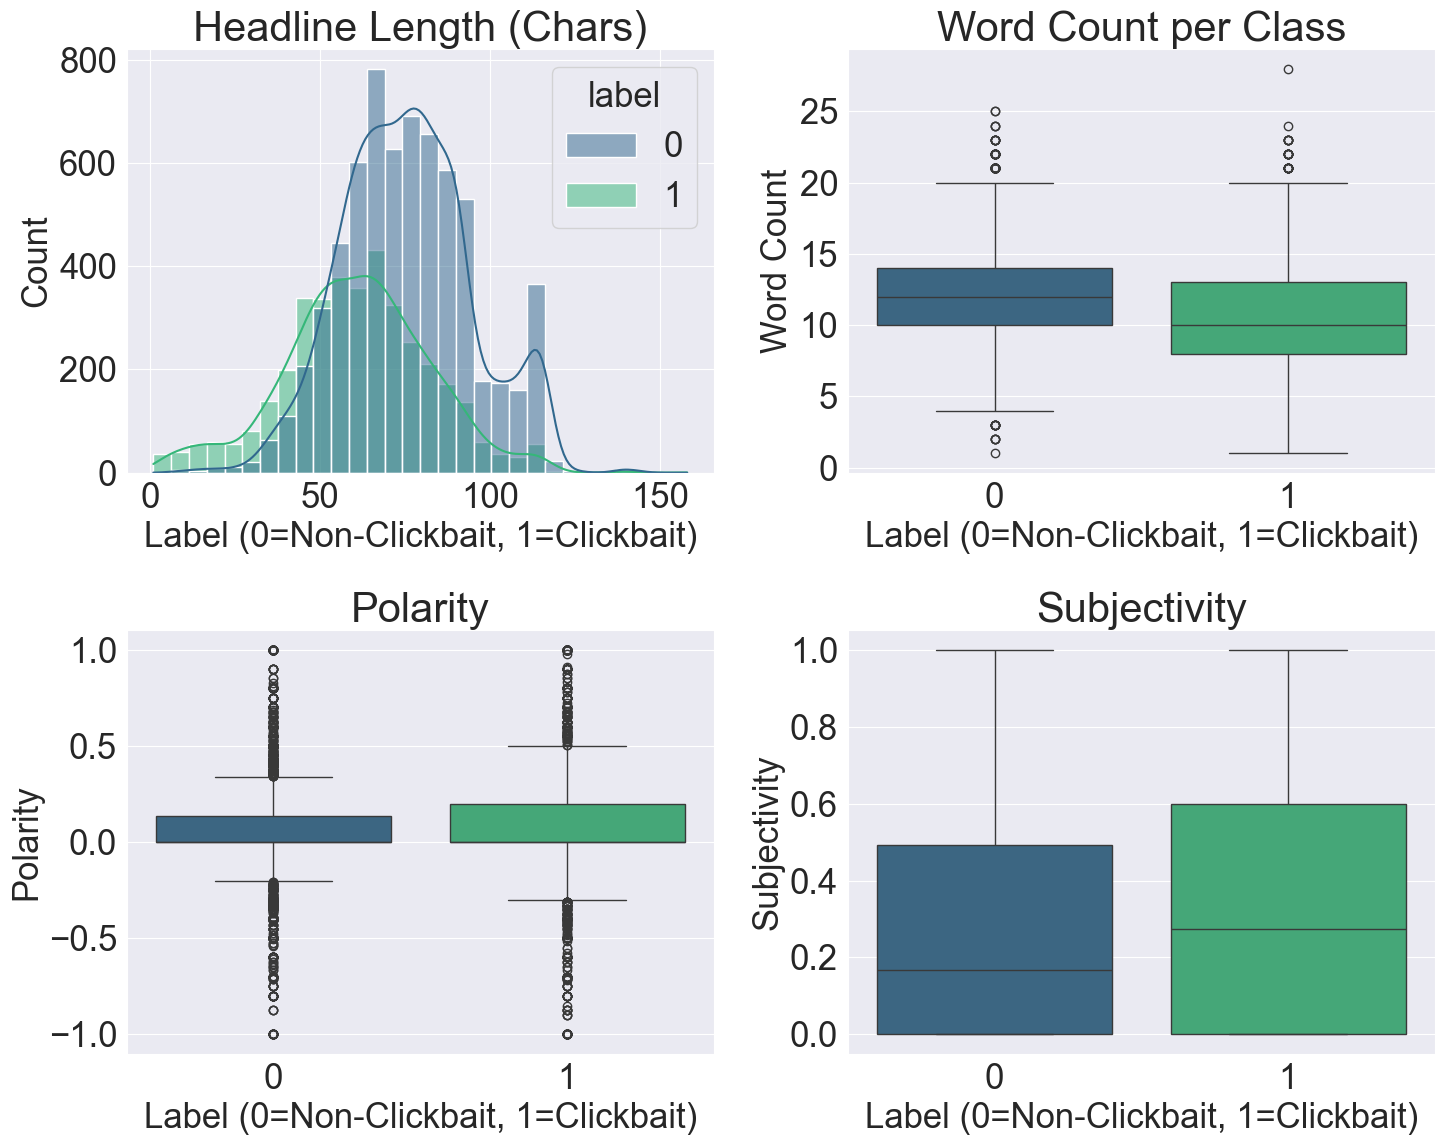

In [13]:
def perform_eda(df):
    extra_features = [
        'ft_polarity',
        'ft_subjectivity',
    ]

    cols = 2
    rows = 2

    plt.figure(figsize=(15, 12))

    # Text Length Histogram
    plt.subplot(rows, cols, 1)
    sns.histplot(data=df, x='ft_char_count', hue='label' if 'label' in df.columns and len(df['label'].unique()) > 1 else None, kde=True, palette='viridis', bins=30)
    plt.xlabel('Label (0=Non-Clickbait, 1=Clickbait)')

    plt.title('Headline Length (Chars)')

    # Word Count Boxplot
    plt.subplot(rows, cols, 2)
    sns.boxplot(x='label', y='ft_word_count', data=df, palette='viridis')
    plt.xlabel('Label (0=Non-Clickbait, 1=Clickbait)')
    plt.ylabel('Word Count')
    plt.title('Word Count per Class')


    for i, feature in enumerate(extra_features):
        plt.subplot(rows, cols, i + 3)
        sns.boxplot(x='label', y=feature, data=df, palette='viridis')
        feature = feature.split("_")[1].capitalize()
        plt.title(feature)
        plt.xlabel('Label (0=Non-Clickbait, 1=Clickbait)')
        plt.ylabel(feature)

    plt.tight_layout()
    plt.show()

print("Visualizing All Features (Original + Extracted)")
perform_eda(final_df)

Visualizing Punctuation and Structural Features


C:\Users\jakub\AppData\Local\Temp\ipykernel_18060\1505007340.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='label', y='has_exclamation', data=prop_excl_presence, palette='viridis')
C:\Users\jakub\AppData\Local\Temp\ipykernel_18060\1505007340.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='label', y='all_caps_present', data=prop_all_caps, palette='viridis')
C:\Users\jakub\AppData\Local\Temp\ipykernel_18060\1505007340.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='label', y='has_question', data=prop_ques_presence, pal

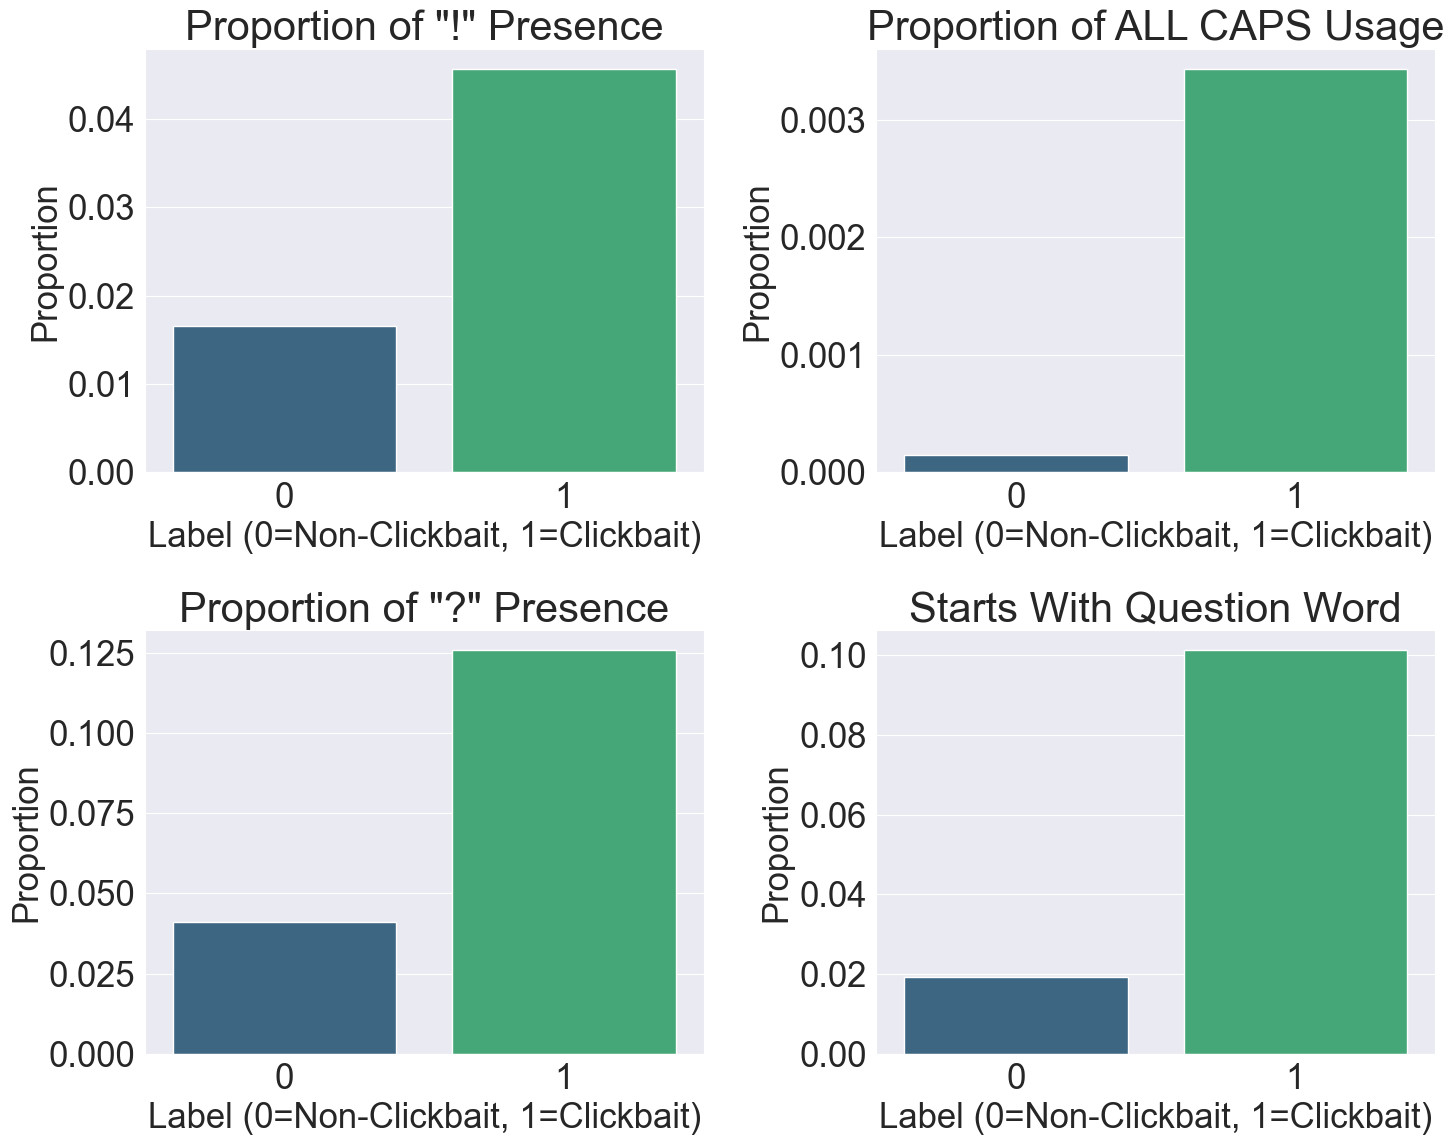

In [14]:
def perform_eda2(df):
    plt.figure(figsize=(15, 12))

    # Exclamation Mark PRESENCE (ft_exclamation >= 1)
    plt.subplot(2, 2, 1)

    # Create binary feature: 1 if >= 1 exclamation mark, 0 otherwise
    df['has_exclamation'] = (df['ft_exclamation'] >= 1).astype(int)

    # Calculate the proportion (mean) of headlines with at least one exclamation mark
    prop_excl_presence = df.groupby('label')['has_exclamation'].mean().reset_index()

    sns.barplot(x='label', y='has_exclamation', data=prop_excl_presence, palette='viridis')
    plt.xlabel('Label (0=Non-Clickbait, 1=Clickbait)')
    plt.ylabel('Proportion')
    plt.title('Proportion of "!" Presence')
    df.drop(columns=['has_exclamation'], inplace=True, errors='ignore')


    # All Caps Presence (ft_all_caps) - REMAINS THE SAME
    plt.subplot(2, 2, 2)
    df['all_caps_present'] = (df['ft_all_caps'] > 0).astype(int)
    prop_all_caps = df.groupby('label')['all_caps_present'].mean().reset_index()

    sns.barplot(x='label', y='all_caps_present', data=prop_all_caps, palette='viridis')
    plt.xlabel('Label (0=Non-Clickbait, 1=Clickbait)')
    plt.ylabel('Proportion')
    plt.title('Proportion of ALL CAPS Usage')
    df.drop(columns=['all_caps_present'], inplace=True, errors='ignore')


    # Question Mark PRESENCE (ft_question >= 1)
    plt.subplot(2, 2, 3)

    # Create binary feature: 1 if >= 1 question mark, 0 otherwise
    df['has_question'] = (df['ft_question'] >= 1).astype(int)

    # Calculate the proportion (mean) of headlines with at least one question mark
    prop_ques_presence = df.groupby('label')['has_question'].mean().reset_index()

    sns.barplot(x='label', y='has_question', data=prop_ques_presence, palette='viridis')
    plt.xlabel('Label (0=Non-Clickbait, 1=Clickbait)')
    plt.ylabel('Proportion')
    plt.title('Proportion of "?" Presence')
    df.drop(columns=['has_question'], inplace=True, errors='ignore')

    # Starts With Question (ft_starts_q)
    plt.subplot(2, 2, 4)
    prop_starts_q = df.groupby('label')['ft_starts_q'].mean().reset_index()

    sns.barplot(x='label', y='ft_starts_q', data=prop_starts_q, palette='viridis')
    plt.xlabel('Label (0=Non-Clickbait, 1=Clickbait)')
    plt.ylabel('Proportion')
    plt.title('Starts With Question Word')

    plt.tight_layout()
    plt.show()

print("Visualizing Punctuation and Structural Features")
perform_eda2(final_df)

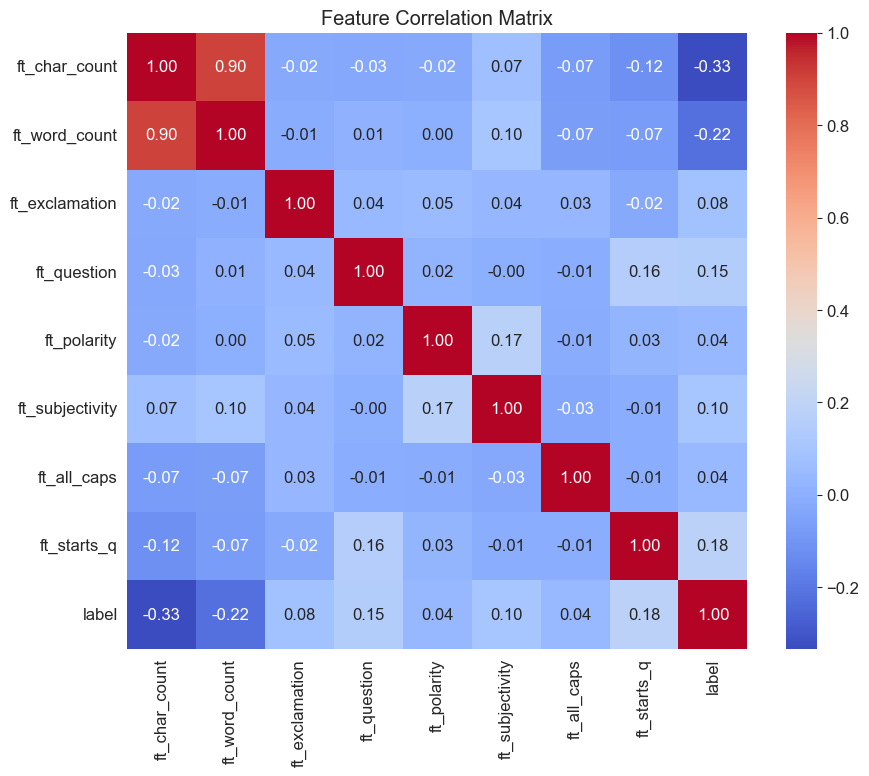

In [15]:
plt.rcParams["font.size"] = 12

# Correlation Matrix
extra_features = [
    'ft_exclamation',
    'ft_question',
    'ft_polarity',
    'ft_subjectivity',
    'ft_all_caps',
    'ft_starts_q'
]

all_numeric = ['ft_char_count', 'ft_word_count'] + extra_features + ['label']
existing_numeric = [c for c in all_numeric if c in final_df.columns]

if len(existing_numeric) > 1:
    plt.figure(figsize=(10, 8))
    corr = final_df[existing_numeric].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Feature Correlation Matrix')
    plt.show()

In [16]:
# extracting X, y pairs
if 'train_df' in locals() and 'val_df' in locals() and 'test_df' in locals():
    X_train = train_df['headline']
    y_train = train_df['label']

    X_val = val_df['headline']
    y_val = val_df['label']
    
    X_test = test_df['headline']
    y_test = test_df['label']

## 4. Model A: Classical Machine Learning
Training a Random Forest on Hand-crafted + TF-IDF features.

In [17]:
if 'X_train' in locals() and 'y_train' in locals() and 'X_val' in locals() and 'y_val' in locals():
    if len(y_train.unique()) < 2:
        print("WARNING: Training data contains only 1 class. Models require at least 2 classes (Clickbait vs Non-Clickbait).")
        print("Consider mixing in non-clickbait data or using a different dataset.")
    else:
        # Build Pipeline
        pipeline_classical = Pipeline([
            ('features', FeatureUnion([
                ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=1000)),
                ('hand_crafted', HandCraftedFeatures())
            ])),
            ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
        ])

        # Hyperparameter tuning using GridSearchCV
        param_grid = {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': [None, 10, 20, 30],
            'classifier__max_features': ['sqrt', 'log2', None]
        }

        grid_search = GridSearchCV(
            pipeline_classical,
            param_grid,
            cv=3,
            scoring='f1',
            n_jobs=-1,
            verbose=2
        )

        # Train
        print("Performing Grid Search for Hyperparameter Tuning...")
        grid_search.fit(X_train, y_train)

        print("\nBest Parameters Found:")
        print(grid_search.best_params_)

        # Evaluate on validation set
        y_pred_val = grid_search.predict(X_val) # will be used to compare effectiveness between different modeling approaches
        print("\n--- Validation Set Results ---")
        print(classification_report(y_val, y_pred_val))


Performing Grid Search for Hyperparameter Tuning...
Fitting 3 folds for each of 36 candidates, totalling 108 fits

Best Parameters Found:
{'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 200}

--- Validation Set Results ---
              precision    recall  f1-score   support

           0       0.82      0.87      0.85      4939
           1       0.75      0.66      0.71      2844

    accuracy                           0.80      7783
   macro avg       0.79      0.77      0.78      7783
weighted avg       0.79      0.80      0.79      7783



In [18]:
# saving the results

if "grid_search" in locals():
    best_params = grid_search.best_params_
    
    y_pred_val = grid_search.predict(X_val)
    
    # classification report
    report_dict = classification_report(y_val, y_pred_val, output_dict=True)
    
    os.makedirs("results/RF", exist_ok=True)
    with open("results/RF/best_params.json", "w") as f:
        json.dump(best_params, f, indent=4)
    
    report_df = pd.DataFrame(report_dict).transpose()
    report_df.to_csv("results/RF/validation_results.csv", index=True)
    
    print("Training results saved")

Training results saved


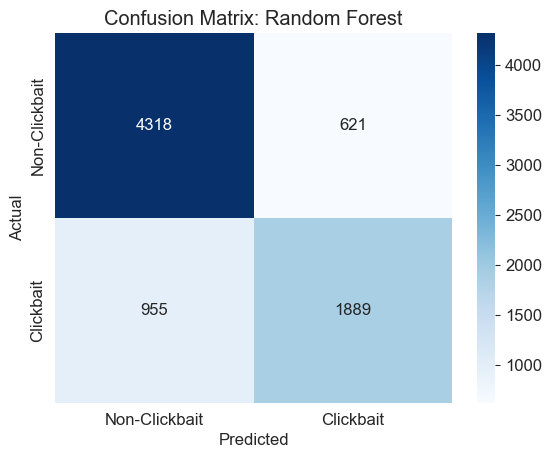

In [19]:
if 'y_val' in locals() and 'y_pred_val' in locals():
    cm = confusion_matrix(y_val, y_pred_val)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Clickbait','Clickbait'], yticklabels=['Non-Clickbait','Clickbait'])
    plt.title('Confusion Matrix: Random Forest')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [24]:
os.makedirs('data/RF', exist_ok=True)

if 'pipeline_classical' in locals():
    pipeline_classical.fit(train_df["headline"], train_df["label"])
    
    X_train_transformed = pipeline_classical.named_steps['features'].transform(train_df["headline"])
    X_val_transformed = pipeline_classical.named_steps['features'].transform(val_df["headline"])
    X_test_transformed = pipeline_classical.named_steps['features'].transform(test_df["headline"])
    
    # If sparse (TF-IDF), save as .npz
    save_npz('data/RF/X_train.npz', X_train_transformed)
    save_npz('data/RF/X_val.npz', X_val_transformed)
    save_npz('data/RF/X_test.npz', X_test_transformed)
    
    pd.Series(train_df["label"]).to_csv('data/RF/y_train.csv', index=False)
    pd.Series(val_df["label"]).to_csv('data/RF/y_val.csv', index=False)
    pd.Series(test_df["label"]).to_csv('data/RF/y_val.csv', index=False)
    
    print("Classical pipeline transformed features saved!")

Classical pipeline transformed features saved!


## 5. Model B: Transformer-based Approach
Fine-tuning DistilBERT.

In [28]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch
import os
import json

# Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_texts = X_train.astype(str).tolist()
val_texts = X_val.astype(str).tolist()
test_texts = X_test.astype(str).tolist()

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=64)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=64)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=64)

class ClickbaitDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = ClickbaitDataset(train_encodings, y_train.tolist())
val_dataset = ClickbaitDataset(val_encodings, y_val.tolist())
test_dataset = ClickbaitDataset(test_encodings, y_test.tolist())

# Model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Metrics
from sklearn.metrics import f1_score, precision_score, recall_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        "f1": f1_score(labels, preds, average="weighted"),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted")
    }

# Training arguments
os.makedirs("results/DistilBert", exist_ok=True)
training_args = TrainingArguments(
    output_dir="./results/DistilBert",
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir="./logs",
    logging_strategy="steps",
    logging_steps=50,
    eval_strategy="steps", # evaluate on validation every eval_steps
    eval_steps=100,
    save_strategy="steps", # save checkpoint every save_steps
    save_steps=100,
    save_total_limit=1, # keep only the best checkpoint
    load_best_model_at_end=True, # automatically reload best checkpoint
    metric_for_best_model="eval_loss",
    greater_is_better=False, # minimizing the loss
    no_cuda=False if torch.cuda.is_available() else True
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train
trainer.train()

# Evaluate on validation
val_metrics = trainer.evaluate()
print("Validation metrics:", val_metrics)

# Save metrics
with open("results/DistilBert/validation_metrics.json", "w") as f:
    json.dump(val_metrics, f, indent=4)


ERROR! Session/line number was not unique in database. History logging moved to new session 102


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,F1,Precision,Recall
100,0.456300,0.458664,0.803845,0.809762,0.809970
200,0.462200,0.427663,0.814410,0.816016,0.813440
300,0.448200,0.430207,0.820277,0.819996,0.820635
400,0.419100,0.423708,0.821329,0.822116,0.820763
500,0.411400,0.409620,0.826186,0.825990,0.826417
600,0.502900,0.511915,0.766960,0.810777,0.787229
700,0.428600,0.394570,0.826367,0.832447,0.824361
800,0.353500,0.439792,0.830415,0.830574,0.830271
900,0.427400,0.379852,0.831393,0.831652,0.831170
1000,0.447900,0.382861,0.829755,0.831126,0.832584


Validation metrics: {'eval_loss': 0.3798517882823944, 'eval_f1': 0.831392638492139, 'eval_precision': 0.8316517639298628, 'eval_recall': 0.8311704998072723, 'eval_runtime': 3.756, 'eval_samples_per_second': 2072.142, 'eval_steps_per_second': 259.051, 'epoch': 2.0}


In [29]:
# Data for training Transformer

os.makedirs('data/transformer', exist_ok=True)

# Training dataset
torch.save(train_dataset.encodings['input_ids'], 'data/transformer/train_input_ids.pt')
torch.save(train_dataset.encodings['attention_mask'], 'data/transformer/train_attention_mask.pt')
torch.save(torch.tensor(y_train.tolist()), 'data/transformer/train_labels.pt')

# Validation dataset
torch.save(val_dataset.encodings['input_ids'], 'data/transformer/val_input_ids.pt')
torch.save(val_dataset.encodings['attention_mask'], 'data/transformer/val_attention_mask.pt')
torch.save(torch.tensor(y_val.tolist()), 'data/transformer/val_labels.pt')

# Test dataset
torch.save(test_dataset.encodings['input_ids'], 'data/transformer/test_input_ids.pt')
torch.save(test_dataset.encodings['attention_mask'], 'data/transformer/test_attention_mask.pt')
torch.save(torch.tensor(y_test.tolist()), 'data/transformer/test_labels.pt')

print("Transformer tokenized features saved!")

Transformer tokenized features saved!


In [30]:
# Load best checkpoint from Trainer
best_model_path = trainer.state.best_model_checkpoint  # Trainer keeps track
best_model = DistilBertForSequenceClassification.from_pretrained(best_model_path)

# Create a new Trainer for evaluation
trainer_best = Trainer(model=best_model, compute_metrics=None)  # metrics optional

# Evaluate
predictions = trainer_best.predict(val_dataset)
y_pred_transformer = np.argmax(predictions.predictions, axis=1)

report = classification_report(y_val, y_pred_transformer, output_dict=True)
print("\n--- Transformer Model Results ---")
print(report)

# Save to file
report_df = pd.DataFrame(report).transpose()
report_df.to_csv("results/DistilBert/validation_results.csv", index=True)

print(f"Classification report saved")


--- Transformer Model Results ---
{'0': {'precision': 0.8696716296145217, 'recall': 0.8633326584328811, 'f1-score': 0.8664905507010771, 'support': 4939.0}, '1': {'precision': 0.765625, 'recall': 0.7753164556962026, 'f1-score': 0.7704402515723271, 'support': 2844.0}, 'accuracy': 0.8311704998072723, 'macro avg': {'precision': 0.8176483148072609, 'recall': 0.8193245570645418, 'f1-score': 0.8184654011367021, 'support': 7783.0}, 'weighted avg': {'precision': 0.8316517639298628, 'recall': 0.8311704998072723, 'f1-score': 0.831392638492139, 'support': 7783.0}}
Classification report saved


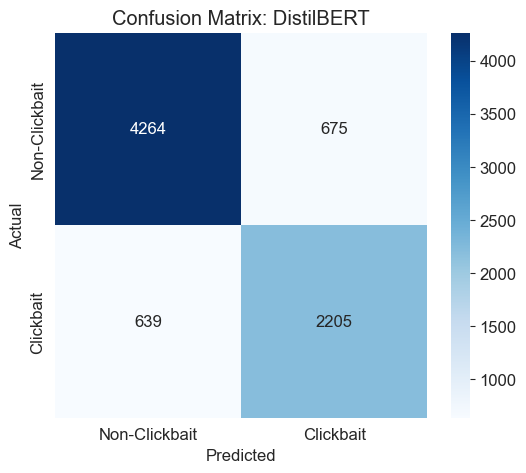

In [34]:
# confusion matrix
cm = confusion_matrix(y_val, y_pred_transformer)

# Plot using Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Clickbait','Clickbait'], yticklabels=['Non-Clickbait','Clickbait'])
plt.title('Confusion Matrix: DistilBERT')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## 6. Feedforward Neural Network

In [20]:
import gensim.downloader as api

# pretrained GloVe embedding
word_vectors = api.load("glove-wiki-gigaword-50")
embedding_dim = 50

In [21]:
def headline_to_avg_embedding(headline, word_vectors, embedding_dim=50):
    words = headline.lower().split()
    vecs = [word_vectors[w] for w in words if w in word_vectors]
    if len(vecs) == 0:
        return np.zeros(embedding_dim)
    return np.mean(vecs, axis=0)

X_train_emb = np.array([headline_to_avg_embedding(h, word_vectors) for h in X_train])
X_val_emb = np.array([headline_to_avg_embedding(h, word_vectors) for h in X_val])
X_test_emb = np.array([headline_to_avg_embedding(h, word_vectors) for h in X_test])

In [23]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# dataset definition
class EmbeddingDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = EmbeddingDataset(X_train_emb, y_train)
val_dataset = EmbeddingDataset(X_val_emb, y_val)
test_dataset = EmbeddingDataset(X_test_emb, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# network definition
class FeedForwardNN(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64, 32], num_classes=2, dropout=0.3):
        super().__init__()
        layers = []
        prev_dim = input_dim
        
        for h_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = h_dim
        
        # Output layer
        layers.append(nn.Linear(prev_dim, num_classes))
        
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FeedForwardNN(embedding_dim).to(device)

In [24]:
os.makedirs("results/FeedForwardNN", exist_ok=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
epochs = 100

best_val_loss = float("inf")
for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
    
    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    all_preds = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
    val_loss /= total
    val_acc = correct / total
    
    print(f"Epoch {epoch+1}: val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "results/FeedForwardNN/best_model.pt")

Epoch 1: val_loss=0.5165, val_acc=0.7487
Epoch 2: val_loss=0.5073, val_acc=0.7606
Epoch 3: val_loss=0.5028, val_acc=0.7617
Epoch 4: val_loss=0.5031, val_acc=0.7581
Epoch 5: val_loss=0.5006, val_acc=0.7601
Epoch 6: val_loss=0.4988, val_acc=0.7655
Epoch 7: val_loss=0.4987, val_acc=0.7647
Epoch 8: val_loss=0.4974, val_acc=0.7647
Epoch 9: val_loss=0.4989, val_acc=0.7642
Epoch 10: val_loss=0.5003, val_acc=0.7628
Epoch 11: val_loss=0.5029, val_acc=0.7608
Epoch 12: val_loss=0.5141, val_acc=0.7635
Epoch 13: val_loss=0.5039, val_acc=0.7662
Epoch 14: val_loss=0.5055, val_acc=0.7602
Epoch 15: val_loss=0.5025, val_acc=0.7664
Epoch 16: val_loss=0.5131, val_acc=0.7604
Epoch 17: val_loss=0.5076, val_acc=0.7662
Epoch 18: val_loss=0.5161, val_acc=0.7641
Epoch 19: val_loss=0.5101, val_acc=0.7638
Epoch 20: val_loss=0.5150, val_acc=0.7617
Epoch 21: val_loss=0.5101, val_acc=0.7605
Epoch 22: val_loss=0.5287, val_acc=0.7642
Epoch 23: val_loss=0.5170, val_acc=0.7593
Epoch 24: val_loss=0.5242, val_acc=0.7497
E

In [25]:
best_val_loss

0.4974064041911736

In [45]:
# saving data

os.makedirs('data/nn', exist_ok=True)

# Training dataset
torch.save(torch.tensor(X_train_emb, dtype=torch.float32), 'data/nn/train_features.pt')
torch.save(torch.tensor(y_train.tolist(), dtype=torch.long), 'data/nn/train_labels.pt')

# Validation dataset
torch.save(torch.tensor(X_val_emb, dtype=torch.float32), 'data/nn/val_features.pt')
torch.save(torch.tensor(y_val.tolist(), dtype=torch.long), 'data/nn/val_labels.pt')

# Test dataset
torch.save(torch.tensor(X_test_emb, dtype=torch.float32), 'data/nn/test_features.pt')
torch.save(torch.tensor(y_test.tolist(), dtype=torch.long), 'data/nn/test_labels.pt')

print("NN embeddings saved")

NN embeddings saved


In [26]:
# saving report on the best model

os.makedirs("results/FeedForwardNN", exist_ok=True)

model.load_state_dict(torch.load("results/FeedForwardNN/best_model.pt"))
model.eval()

y_pred = []
with torch.no_grad():
    for X_batch, _ in val_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = outputs.argmax(dim=1)
        y_pred.extend(preds.cpu().numpy())

report = classification_report(y_val, y_pred, output_dict=True)
print(report)

report_df = pd.DataFrame(report).transpose()
report_df.to_csv("results/FeedForwardNN/validation_results.csv", index=True)

{'0': {'precision': 0.7869276218611522, 'recall': 0.8629277181615712, 'f1-score': 0.8231772090777402, 'support': 4939.0}, '1': {'precision': 0.7139839459231094, 'recall': 0.5942334739803095, 'f1-score': 0.6486279025139129, 'support': 2844.0}, 'accuracy': 0.7647436721058718, 'macro avg': {'precision': 0.7504557838921309, 'recall': 0.7285805960709404, 'f1-score': 0.7359025557958265, 'support': 7783.0}, 'weighted avg': {'precision': 0.7602731423072792, 'recall': 0.7647436721058718, 'f1-score': 0.7593948336611239, 'support': 7783.0}}


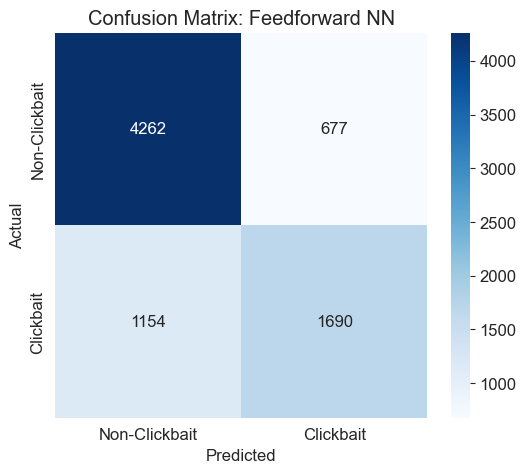

In [27]:
# confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Plot using Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Clickbait','Clickbait'], yticklabels=['Non-Clickbait','Clickbait'])
plt.title('Confusion Matrix: Feedforward NN')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 7. Clickbaitness measure

In [40]:
from prepare_data import *
from measure import baitness_measure
import numpy as np
X_test = pd.read_csv(r'data\merged\test.csv').to_numpy()

In [43]:
baitnes = [0] * len(X_test)
for i,x in enumerate(X_test):
    baitnes[i] = baitness_measure(x[1])

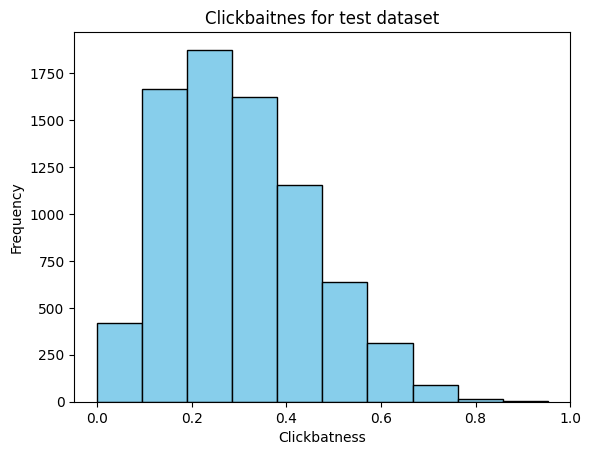

In [ ]:
import matplotlib.pyplot as plt

baitnes_np = np.array(baitnes)

# Plot histogram
plt.hist(baitnes_np, bins=10, color='skyblue', edgecolor='black')
plt.title('Clickbaitness for test dataset')
plt.xlabel('Clickbaitness')
plt.ylabel('Frequency')
plt.show()

In [45]:
import torch
import torch.nn as nn

df_test = torch.load(r"data\nn\test_features.pt")

if not isinstance(df_test, torch.Tensor):
    df_test = torch.tensor(df_test, dtype=torch.float32)

class ClickbaitModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(50, 128),  # net.0
            nn.ReLU(),           # net.1
            nn.Dropout(0.2),     # net.2
            nn.Linear(128, 64),  # net.3
            nn.ReLU(),           # net.4
            nn.Dropout(0.2),     # net.5
            nn.Linear(64, 32),   # net.6
            nn.ReLU(),           # net.7
            nn.Dropout(0.2),     # net.8
            nn.Linear(32, 2)     # net.9
        )

    def forward(self, x):
        return self.net(x)
    

model = ClickbaitModel()
state_dict = torch.load(r"results\FeedForwardNN\best_model.pt", map_location="cpu")
model.load_state_dict(state_dict)

model.eval()

with torch.no_grad():
    logits = model(df_test)
    probs = torch.softmax(logits, dim=1)


## 7. Inference Demo

In [40]:
def predict_headline(text):
    print(f"Headline: '{text}'")

    # Classical Prediction
    if 'pipeline_classical' in globals():
        prob_classical = pipeline_classical.predict_proba([text])[0][1]
        print(f"   > Classical Model Clickbait Probability: {prob_classical:.4f}")

    # Transformer Prediction
    if 'model' in globals():
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=64).to(model.device)
        with torch.no_grad():
            logits = model(**inputs).logits
        prob_transformer = torch.softmax(logits, dim=1)[0][1].item()
        print(f"   > Transformer Model Clickbait Probability: {prob_transformer:.4f}")
    print("-"*50)

predict_headline("10 celebs who aged terribly - number 5 will shock you!")
predict_headline("Market stabilizes after recent volatility")

Headline: '10 celebs who aged terribly - number 5 will shock you!'
   > Classical Model Clickbait Probability: 0.6300
   > Transformer Model Clickbait Probability: 0.9999
--------------------------------------------------
Headline: 'Market stabilizes after recent volatility'
   > Classical Model Clickbait Probability: 0.1700
   > Transformer Model Clickbait Probability: 0.0000
--------------------------------------------------
